In [1]:
import math
import numpy as np
import pandas as pd

import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime as dt

import os
import json
import time
import matplotlib.pyplot as plt


In [2]:
class get_data():
    

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split  ]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def normalize_windows(self, window_data, single_window=False):
        
        normalized_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalized_window = []
            for col_i in range(window.shape[1]):
                normalized_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalized_window.append(normalized_col)
            normalized_window = np.array(normalized_window).T 
            normalized_data.append(normalized_window)
        return np.array(normalized_data)
    
    def next_window(self, i, seq_len, normalize):
        
        window = self.data_train[i:i+seq_len]
        window = self.normalize_windows(window, single_window=True)[0] if normalize else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y
     
    
    def get_test_data(self, seq_len, normalize):
    
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalize_windows(data_windows, single_window=False) if normalize else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalize):
        
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self.next_window(i, seq_len, normalize)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def train_batch(self, seq_len, batch_size, normalize):
    
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self.next_window(i, seq_len, normalize)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)


class Timer():

    def __init__(self):
        self.start_dt = None

    def start(self):
        self.start_dt = dt.datetime.now()

    def stop(self):
        end_dt = dt.datetime.now()
        print('Total Time: %s' % (end_dt - self.start_dt))


class Model():

    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model = load_model(filepath)

    def build_model(self, params):
        timer = Timer()
        timer.start()

        for layer in params['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=params['model']['loss'], optimizer=params['model']['optimizer'])

        print('Model Compilation Completed...')
        timer.stop()


    def train(self, data_gen, epochs, batch_size, steps_per_epoch, save_folder):
        timer = Timer()
        timer.start()
        print('Training Started...')
        print('Number of Eopochs: %s , Batch Size: %s, Number of Batches per Epoch: %s' % (epochs, batch_size, steps_per_epoch))

        save_fname = os.path.join(save_folder, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
        ]
        self.model.fit(
            data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks,
            workers=1
        )

        print('Training Completed...')
        timer.stop()

    def predict_point_by_point(self, data):
        
        print('Now Predicting Point-by-Point...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted
    
    def predict_multi_seq(self, data, window_size, prediction_len):
        
        print('Now Predicting Multi-Sequence...')
        prediction_seqs = []
        for i in range(int(len(data)/prediction_len)):
            curr_frame = data[i*prediction_len]
            predicted = []
            for j in range(prediction_len):
                predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

Model Compilation Completed...
Total Time: 0:00:01.611494
Training Started...
Number of Eopochs: 1 , Batch Size: 32, Number of Batches per Epoch: 148
148/148 [==============================] - 70s 476ms/step - loss: 5.3950e-04
Training Completed...
Total Time: 0:01:16.612806
Now Predicting Point-by-Point...
Now Predicting Multi-Sequence...


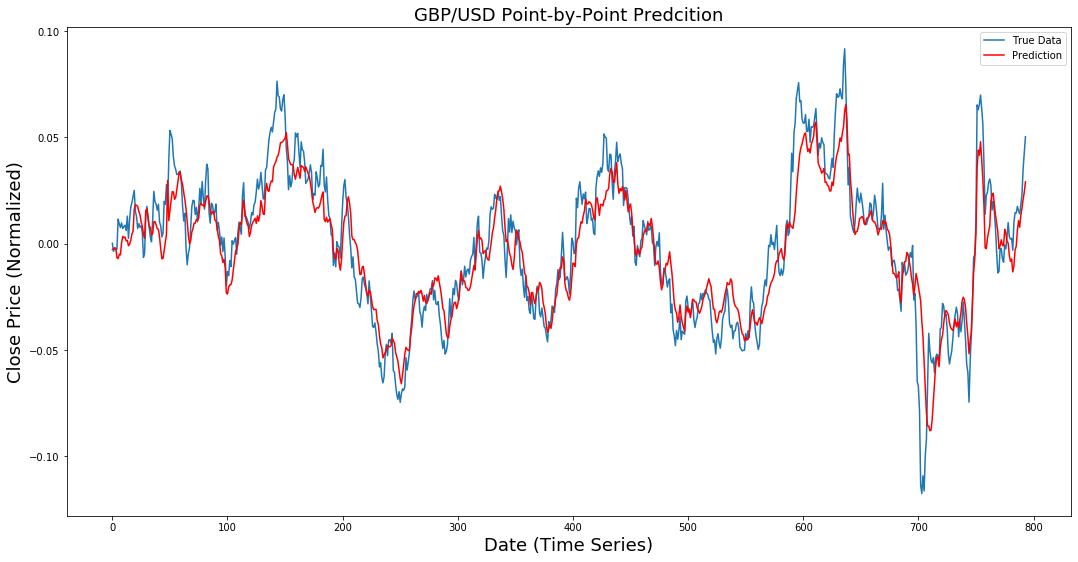

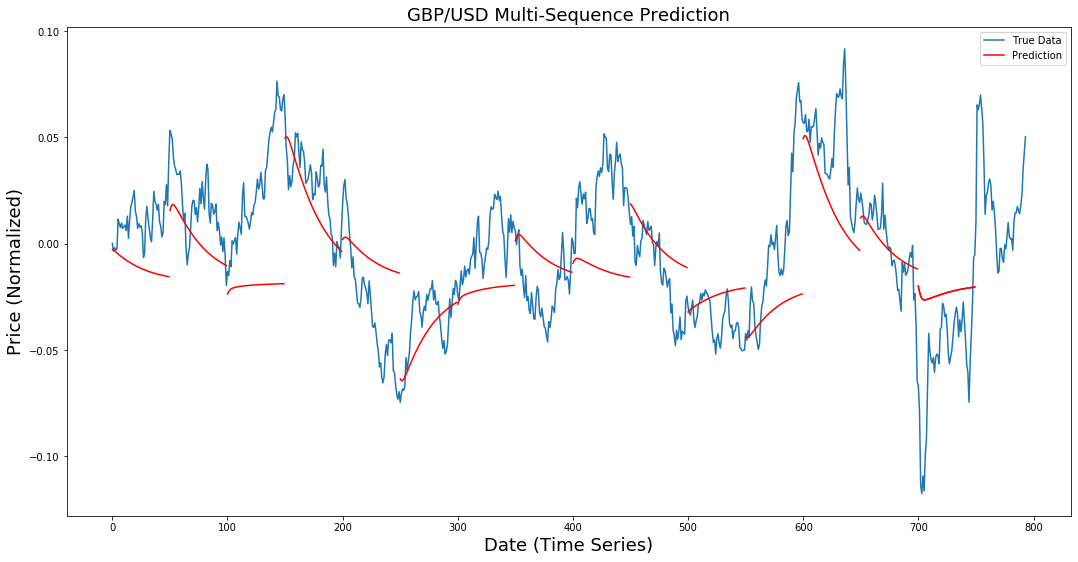

In [3]:
def plot_point_by_point(predicted_data, true_data):
    fig = plt.figure(facecolor='white',figsize = (18,9))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction', color = 'r')
    plt.title('GBP/USD Point-by-Point Predcition',fontsize=18)
    plt.xlabel('Date (Time Series)',fontsize=18)
    plt.ylabel('Close Price (Normalized)',fontsize=18)
    plt.legend()
    plt.show()


def plot_multi_seq(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white',figsize = (18,9))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data,color='r')
    plt.plot(padding + data,label = 'Prediction',color='r')
    plt.title('GBP/USD Multi-Sequence Prediction',fontsize=18)
    plt.xlabel('Date (Time Series)',fontsize=18)
    plt.ylabel('Price (Normalized)',fontsize=18)
    plt.legend()
    plt.show()


def main():
    params = json.load(open('param.json', 'r'))
    if not os.path.exists(params['model']['save_folder']): os.makedirs(params['model']['save_folder'])

    data = get_data(
        os.path.join('data', params['data']['filename']),
        params['data']['train_test_split'],
        params['data']['columns']
    )

    model = Model()
    model.build_model(params)
    x, y = data.get_train_data(
        seq_len=params['data']['sequence_length'],
        normalize=params['data']['normalize']
    )

    
    steps_per_epoch = math.ceil((data.len_train - params['data']['sequence_length']) / params['training']['batch_size'])
    model.train(
        data_gen=data.train_batch(
            seq_len=params['data']['sequence_length'],
            batch_size=params['training']['batch_size'],
            normalize=params['data']['normalize']
        ),
        epochs=params['training']['epochs'],
        batch_size=params['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_folder=params['model']['save_folder']
    )

    x_test, y_test = data.get_test_data(
        seq_len=params['data']['sequence_length'],
        normalize=params['data']['normalize']
    )

    
    predictions_pointbypoint = model.predict_point_by_point(x_test)
    predictions_multiseq = model.predict_multi_seq(x_test, params['data']['sequence_length'], params['data']['sequence_length'])

    plot_point_by_point(predictions_pointbypoint, y_test)
    plot_multi_seq(predictions_multiseq, y_test, params['data']['sequence_length'])

if __name__ == '__main__':
    main()